In [1]:
import os
import pandas as pd
import random
from copy import deepcopy
from collections import defaultdict
import geopandas as gp
from matplotlib import pyplot as plt
from pam import parse
from pam.core import Population, Household, Person
from pam.activity import Plan, Activity, Leg
from pam.utils import minutes_to_datetime as mtdt
from pam.variables import END_OF_DAY

from pam.modify import *

In [9]:
def plot_activities(person):
    #Load a df with a persons activty plan
    activities, start_times, end_times, durations = [], [], [], []
    for component in person.plan.day:
        activities.append(component.act.title())
        start_times.append(component.start_time.hour + component.start_time.minute/60)
        end_times.append(component.end_time.hour + component.end_time.minute/60)
        durations.append(component.duration.total_seconds()/3600)
    df = pd.DataFrame(zip(activities,start_times,durations), columns=['act','start_time','dur'])
    #Define a colour map for a unique list of activities
    colors = plt.cm.tab10.colors
    activities_unique = df['act'].unique()
    d_color = dict(zip(activities_unique,colors))
    df['color'] = df['act'].map(d_color)
    #Plotting
    fig,ax = plt.subplots(figsize=(16,4))
    
    label_x, label_y = [],[]
    for i in range(len(df)):
        y = 1
        data = df.iloc[i]
        ax.barh(y, 
                width='dur', 
                data=data,
                left='start_time',
                label='act',
                color='color'
               )
        
        #Populate Labelling Params
        label_x.append(data['start_time']+data['dur']/2)
        label_y.append(y)
    
    #Labels
    rects = ax.patches
    
    for x, y, rect, activity in zip(label_x, label_y, rects, activities):
        if rect.get_width()>=3:
            ax.text(x, y, activity, ha='center',
                    fontdict={'color':'white', 'size':14, 'weight':'bold'})
        
    plt.xticks(range(25))
    plt.xlim(right=24)
    ax.get_yaxis().set_visible(False)
    
def print_simple_stats(population):
    """
    Print some simple population statistics.
    """
    time_at_home = 0
    travel_time = 0 
    low_income_central_trips = 0
    high_income_central_trips = 0
    
    for hid, hh in population.households.items():
        for pid, person in hh.people.items():
            freq = person.freq
            
            for p in person.plan:
                if p.act == 'travel':
                    duration = p.duration.seconds * freq / 3600
                    travel_time += duration
                    
                    if p.end_location.area == "Westminster,City of London":
                        if person.attributes['inc'] == "low":
                            low_income_central_trips += freq
                            
                        elif person.attributes['inc'] == "high":
                            high_income_central_trips += freq
                    
                else:  # activity
                    if p.act == 'home':
                        duration = p.duration.seconds * freq / 3600
                        time_at_home += duration
                        
    print(f"Population total time at home: {time_at_home:.2f} hours")
    print(f"Population total travel time: {travel_time:.2f} hours")

## Create example Population

In [10]:
population = Population()

### Add Smith household

In [11]:
smith_id = 'Smith'

Bobby = Person('Bobby', attributes={'age': 6, 'job': 'education', 'gender': 'male', 'key_worker': False})
Bobby.add(Activity(1, 'home', 'a', start_time=mtdt(0), end_time=mtdt(8 * 60)))
Bobby.add(Leg(1, 'walk', 'a', 'b', start_time=mtdt(8 * 60), end_time=mtdt(8 * 60 + 30)))
Bobby.add(Activity(2, 'education', 'b', start_time=mtdt(8 * 60 + 30), end_time=mtdt(16 * 60)))
Bobby.add(Leg(2, 'walk', 'b', 'c', start_time=mtdt(16 * 60), end_time=mtdt(16 * 60 + 30)))
Bobby.add(Activity(3, 'home', 'a', start_time=mtdt(16 * 60 + 30), end_time=END_OF_DAY))

Betty = Person('Betty', attributes={'age': 40, 'job': 'work', 'gender': 'female', 'key_worker': True})
Betty.add(Activity(1, 'home', 'a', start_time=mtdt(0), end_time=mtdt(8 * 60)))
Betty.add(Leg(1, 'walk', 'a', 'b', start_time=mtdt(8 * 60), end_time=mtdt(8 * 60 + 5)))
Betty.add(Activity(2, 'escort', 'b', start_time=mtdt(8 * 60 + 5), end_time=mtdt(8 * 60 + 30)))
Betty.add(Leg(2, 'pt', 'a', 'b', start_time=mtdt(8 * 60), end_time=mtdt(8 * 60 + 30)))
Betty.add(Activity(3, 'work', 'b', start_time=mtdt(8 * 60 + 30), end_time=mtdt(14 * 60)))
Betty.add(Leg(3, 'pt', 'b', 'c', start_time=mtdt(14 * 60), end_time=mtdt(14 * 60 + 20)))
Betty.add(Activity(4, 'leisure', 'c', start_time=mtdt(14 * 60 + 20), end_time=mtdt(16 * 60 - 20)))
Betty.add(Leg(4, 'pt', 'c', 'b', start_time=mtdt(16 * 60 - 20), end_time=mtdt(16 * 60)))
Betty.add(Activity(5, 'escort', 'b', start_time=mtdt(16 * 60), end_time=mtdt(16 * 60 + 30)))
Betty.add(Leg(5, 'walk', 'a', 'b', start_time=mtdt(16 * 60 + 30), end_time=mtdt(16 * 60 + 5)))
Betty.add(Activity(6, 'home', 'a', start_time=mtdt(16 * 60 + 5), end_time=END_OF_DAY))

smiths = Household(smith_id)
for person in [Bobby, Betty]:
    smiths.add(person)

smiths.people

{'Bobby': <pam.core.Person at 0x1198b2610>,
 'Betty': <pam.core.Person at 0x1198b2990>}

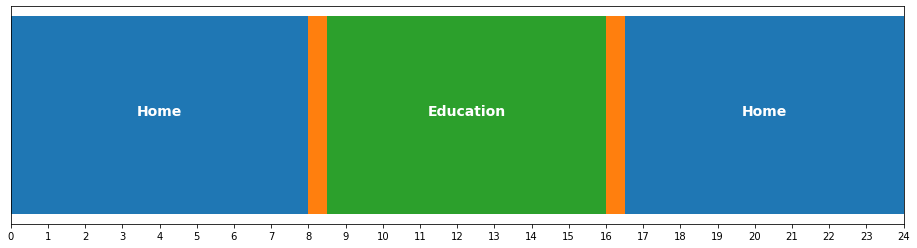

In [12]:
plot_activities(Bobby)

In [13]:
Betty.plan.print()

0:	Activity(1 act:home, location:a, time:00:00:00 --> 08:00:00, duration:8:00:00)
1:	Leg(1 mode:walk, area:a --> b, time:08:00:00 --> 08:05:00, duration:0:05:00)
2:	Activity(2 act:escort, location:b, time:08:05:00 --> 08:00:00, duration:-1 day, 23:55:00)
3:	Leg(2 mode:pt, area:a --> b, time:08:00:00 --> 08:30:00, duration:0:30:00)
4:	Activity(3 act:work, location:b, time:08:30:00 --> 14:00:00, duration:5:30:00)
5:	Leg(3 mode:pt, area:b --> c, time:14:00:00 --> 14:20:00, duration:0:20:00)
6:	Activity(4 act:leisure, location:c, time:14:20:00 --> 15:40:00, duration:1:20:00)
7:	Leg(4 mode:pt, area:c --> b, time:15:40:00 --> 16:00:00, duration:0:20:00)
8:	Activity(5 act:escort, location:b, time:16:00:00 --> 16:30:00, duration:0:30:00)
9:	Leg(5 mode:walk, area:a --> b, time:16:30:00 --> 16:05:00, duration:-1 day, 23:35:00)
10:	Activity(6 act:home, location:a, time:16:05:00 --> 00:00:00, duration:7:55:00)


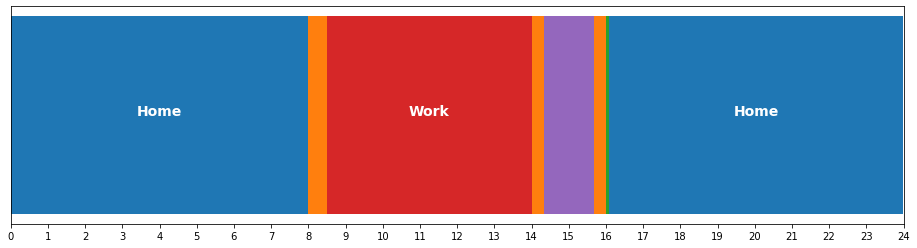

In [14]:
plot_activities(Betty)

In [15]:
population.add(smiths)

### Add Jones household

In [16]:
jones_id = 'Jones'

Hugh = Person('Hugh', attributes={'age': 100, 'job': 'unemployed', 'gender': 'male', 'key_worker': False})
Hugh.add(Activity(1, 'home', 'a', start_time=mtdt(0), end_time=mtdt(8 * 60)))
Hugh.add(Leg(1, 'walk', 'a', 'b', start_time=mtdt(8 * 60), end_time=mtdt(8 * 60 + 30)))
Hugh.add(Activity(2, 'health', 'b', start_time=mtdt(8 * 60 + 30), end_time=mtdt(10 * 60)))
Hugh.add(Leg(2, 'walk', 'b', 'a', start_time=mtdt(10 * 60), end_time=mtdt(10 * 60 + 30)))
Hugh.add(Activity(3, 'home', 'a', start_time=mtdt(10 * 60 + 30), end_time=mtdt(14 * 60)))
Hugh.add(Leg(3, 'walk', 'a', 'b', start_time=mtdt(14 * 60), end_time=mtdt(14 * 60 + 30)))
Hugh.add(Activity(4, 'health', 'b', start_time=mtdt(14 * 60 + 30), end_time=mtdt(16 * 60)))
Hugh.add(Leg(4, 'walk', 'b', 'a', start_time=mtdt(16 * 60), end_time=mtdt(16 * 60 + 30)))
Hugh.add(Activity(5, 'home', 'a', start_time=mtdt(16 * 60 + 30), end_time=END_OF_DAY))

Bridget = Person('Bridget', attributes={'age': 35, 'job': 'work', 'gender': 'female', 'key_worker': False})
Bridget.add(Activity(1, 'home', 'a', start_time=mtdt(0), end_time=mtdt(8 * 60)))
Bridget.add(Leg(1, 'walk', 'a', 'b', start_time=mtdt(8 * 60), end_time=mtdt(8 * 60 + 5)))
Bridget.add(Activity(2, 'escort', 'b', start_time=mtdt(8 * 60 + 5), end_time=mtdt(10 * 60 + 30)))
Bridget.add(Leg(2, 'pt', 'b', 'c', start_time=mtdt(10 * 60 + 30), end_time=mtdt(11 * 60)))
Bridget.add(Activity(3, 'work', 'c', start_time=mtdt(11 * 60), end_time=mtdt(16 * 60)))
Bridget.add(Leg(3, 'pt', 'c', 'a', start_time=mtdt(16 * 60), end_time=mtdt(16 * 60 + 20)))
Bridget.add(Activity(4, 'home', 'a', start_time=mtdt(16 * 60 + 20), end_time=mtdt(17 * 60 + 20)))
Bridget.add(Leg(4, 'pt', 'c', 'a', start_time=mtdt(17 * 60 + 20), end_time=mtdt(17 * 60 + 50)))
Bridget.add(Activity(5, 'shop', 'a', start_time=mtdt(17 * 60 + 50), end_time=mtdt(18 * 60 + 30)))
Bridget.add(Leg(5, 'pt', 'c', 'a', start_time=mtdt(18 * 60 + 30), end_time=mtdt(18 * 60 + 50)))
Bridget.add(Activity(6, 'home', 'a', start_time=mtdt(18 * 60 + 50), end_time=END_OF_DAY))

jones = Household(jones_id)
for person in [Hugh, Bridget]:
    jones.add(person)

jones.people

{'Hugh': <pam.core.Person at 0x11bb8e390>,
 'Bridget': <pam.core.Person at 0x11bb8e990>}

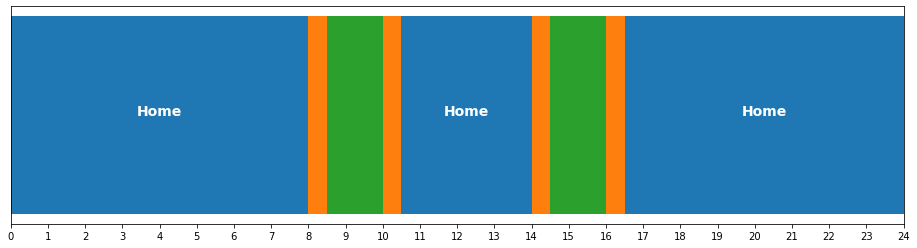

In [17]:
plot_activities(Hugh)

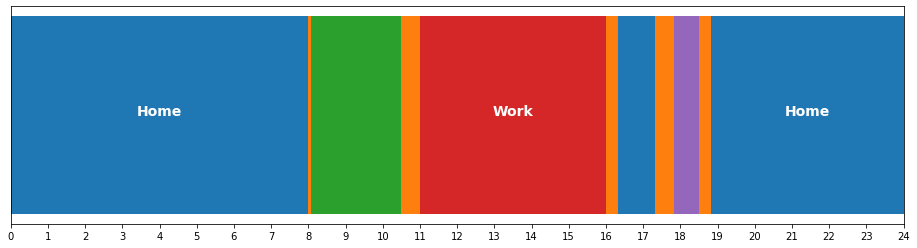

In [18]:
plot_activities(Bridget)

In [19]:
population.add(jones)

In [20]:
print_simple_stats(population)

Population total time at home: 64.58 hours
Population total travel time: 29.58 hours


# PAM Complex Policies

Based on [link](https://docs.google.com/spreadsheets/d/1FQMa7dLe2cv1NEZnbu5cZo3v07tKXINwvOaLQYoEp-M/edit#gid=0)

In [21]:
def apply_policies(population, policies: list):

    new_population = deepcopy(population) 
    for hid, household in new_population.households.items():
        for policy in policies:
            policy.apply_to(household)
    return new_population

In [22]:
def discrete_joint_distribution_sampler(obj, mapping, distribution):
    """
    Randomly sample from a joint distribution based some discrete features.
    Where features are a dictionary structure of features, eg: {'gender':'female'}
    Distribution is a nested dict of probabilities based on possible features, eg:
    {'0-0': {'male': 0, 'female': 0},... , '90-120': {'male': 1, 'female': 1}}
    Mapping provides the feature name for each level of the distribution, eg:
    ['age', 'gender']
    """
    p = distribution
    for key in mapping:
        value = obj.attributes.get(key)
        if value is None:
            raise KeyError(f"Cannot find mapping: {key} in sampling features: {features}")
        p = p.get(value)
        if p is None:
            raise KeyError(f"Cannot find feature for {key}: {value} in distribution: {p}")

    return p

In [23]:
vulnerable_mapping = ['age', 'gender']
vulnerable_distribution = dict(zip(list(range(101)), [{'male': i/100, 'female': i/100, 'other': i/100} for i in range(101)]))

In [24]:
dict(list(vulnerable_distribution.items())[0:15])

{0: {'male': 0.0, 'female': 0.0, 'other': 0.0},
 1: {'male': 0.01, 'female': 0.01, 'other': 0.01},
 2: {'male': 0.02, 'female': 0.02, 'other': 0.02},
 3: {'male': 0.03, 'female': 0.03, 'other': 0.03},
 4: {'male': 0.04, 'female': 0.04, 'other': 0.04},
 5: {'male': 0.05, 'female': 0.05, 'other': 0.05},
 6: {'male': 0.06, 'female': 0.06, 'other': 0.06},
 7: {'male': 0.07, 'female': 0.07, 'other': 0.07},
 8: {'male': 0.08, 'female': 0.08, 'other': 0.08},
 9: {'male': 0.09, 'female': 0.09, 'other': 0.09},
 10: {'male': 0.1, 'female': 0.1, 'other': 0.1},
 11: {'male': 0.11, 'female': 0.11, 'other': 0.11},
 12: {'male': 0.12, 'female': 0.12, 'other': 0.12},
 13: {'male': 0.13, 'female': 0.13, 'other': 0.13},
 14: {'male': 0.14, 'female': 0.14, 'other': 0.14}}

In [25]:
discrete_joint_distribution_sampler(Bobby, vulnerable_mapping, vulnerable_distribution)

0.06

## Household Quarantine

Probabilistically apply quarantine to a household (remove all activities - stay at home) 

### Person-based, all people equal

If you have a probability of any person having to be quarantined

In [26]:
policy_quarantine = \
    HouseholdPolicy(
        RemoveActivity(['work', 'health', 'leisure', 'escort', 'shop', 'education']), 
        PersonProbability(0.0000000000001)
)

In [27]:
q_pop = apply_policies(population, [policy_quarantine])
print_simple_stats(q_pop)

Population total time at home: 64.58 hours
Population total travel time: 29.58 hours


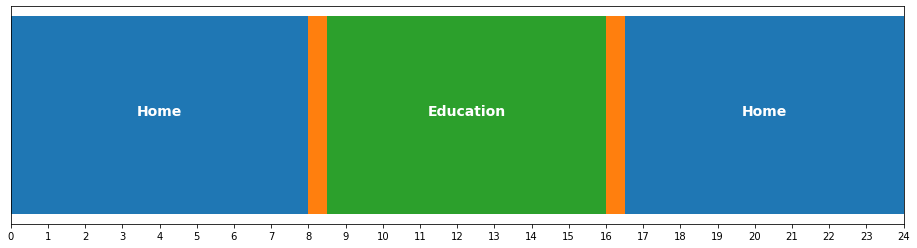

In [28]:
plot_activities(q_pop.households['Smith'].people['Bobby'])

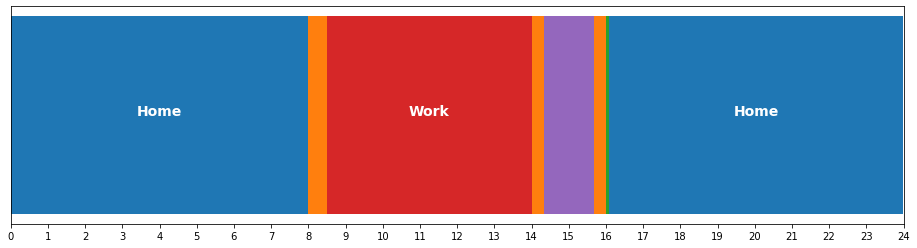

In [29]:
plot_activities(q_pop.households['Smith'].people['Betty'])

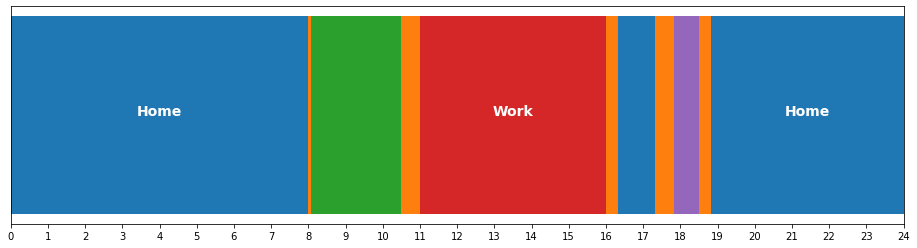

In [30]:
plot_activities(q_pop.households['Jones'].people['Bridget'])

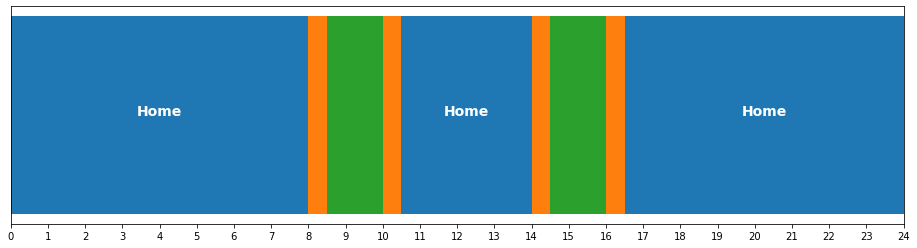

In [31]:
plot_activities(q_pop.households['Jones'].people['Hugh'])

### Using joint distribution

In [32]:
policy_quarantine = \
    HouseholdPolicy(
        RemoveActivity(['work', 'health', 'escort', 'leisure', 'shop', 'education']), 
        PersonProbability(
             discrete_joint_distribution_sampler, 
             dict(mapping=vulnerable_mapping, distribution=vulnerable_distribution))
)

In [33]:
q_pop = apply_policies(population, [policy_quarantine])
print_simple_stats(q_pop)

Population total time at home: 31.42 hours
Population total travel time: 25.83 hours


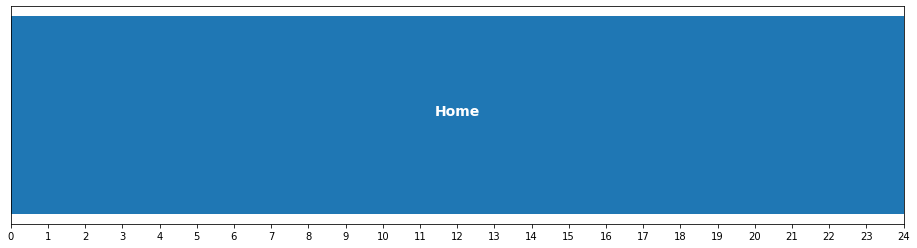

In [34]:
plot_activities(q_pop.households['Jones'].people['Bridget'])

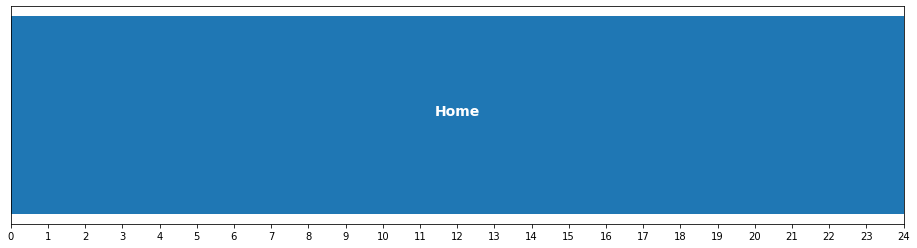

In [35]:
plot_activities(q_pop.households['Jones'].people['Hugh'])

### Chaining probabilities

In [36]:
policy_quarantine = \
    HouseholdPolicy(
        RemoveActivity(['work', 'health', 'escort', 'leisure', 'shop', 'education']), 
        [PersonProbability(0.5), 
         PersonProbability(
             discrete_joint_distribution_sampler, 
             dict(mapping=vulnerable_mapping, distribution=vulnerable_distribution))]
)

In [37]:
q_pop = apply_policies(population, [policy_quarantine])
print_simple_stats(q_pop)

Population total time at home: 64.58 hours
Population total travel time: 29.58 hours


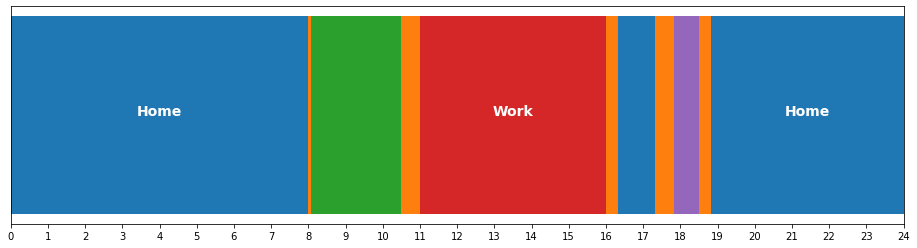

In [38]:
plot_activities(q_pop.households['Jones'].people['Bridget'])

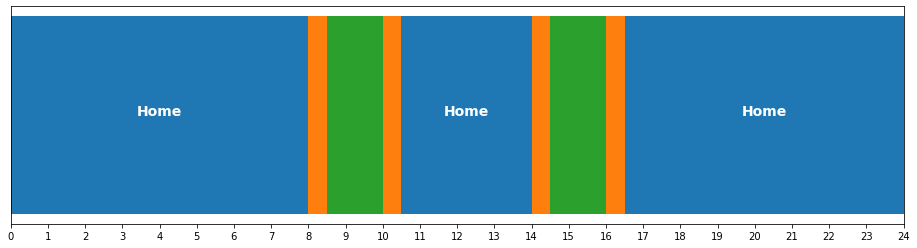

In [39]:
plot_activities(q_pop.households['Jones'].people['Hugh'])

## Remove Education

Probabilistically remove education activities from a person and escort from people in the same household

In [40]:
edu_mapping = ['job']
edu_distribution = {'work': 0, 'unemployed': 0, 'education': 1}

In [41]:
key_mapping = ['key_worker']
key_distribution = {True: 0, False: 1}

In [42]:
edu_distribution, key_distribution

({'work': 0, 'unemployed': 0, 'education': 1}, {True: 0, False: 1})

In [43]:
policy_remove_education_and_escort = \
    HouseholdPolicy(
        RemoveActivity(['education', 'escort']), 
        [PersonProbability(
             discrete_joint_distribution_sampler, 
             dict(mapping=edu_mapping, distribution=edu_distribution)),
         PersonProbability(
             discrete_joint_distribution_sampler, 
             dict(mapping=key_mapping, distribution=key_distribution))])

In [44]:
edu_pop = apply_policies(population, [policy_remove_education_and_escort])
print_simple_stats(edu_pop)

Population total time at home: 49.58 hours
Population total travel time: 4.50 hours


In [45]:
edu_pop.households['Smith'].people['Betty'].plan.print()

0:	Activity(1 act:home, location:a, time:00:00:00 --> 08:00:00, duration:8:00:00)
1:	Leg(1 mode:walk, area:a --> b, time:08:00:00 --> 08:05:00, duration:0:05:00)
2:	Activity(3 act:work, location:b, time:08:05:00 --> 13:35:00, duration:5:30:00)
3:	Leg(3 mode:pt, area:b --> c, time:13:35:00 --> 13:55:00, duration:0:20:00)
4:	Activity(4 act:leisure, location:c, time:13:55:00 --> 15:15:00, duration:1:20:00)
5:	Leg(4 mode:pt, area:c --> b, time:15:15:00 --> 15:35:00, duration:0:20:00)
6:	Activity(6 act:home, location:a, time:15:35:00 --> 00:00:00, duration:8:25:00)


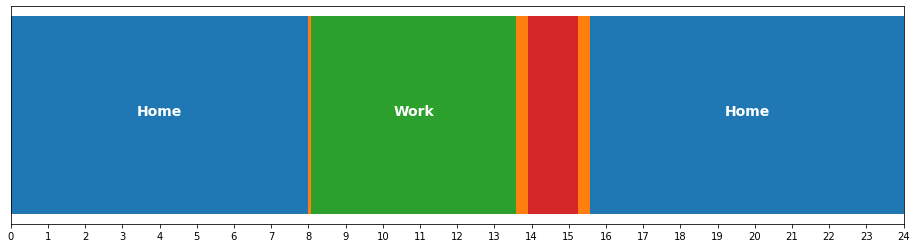

In [46]:
plot_activities(edu_pop.households['Smith'].people['Betty'])

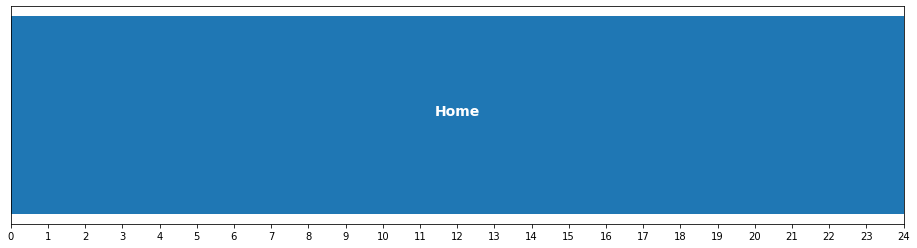

In [47]:
plot_activities(edu_pop.households['Smith'].people['Bobby'])

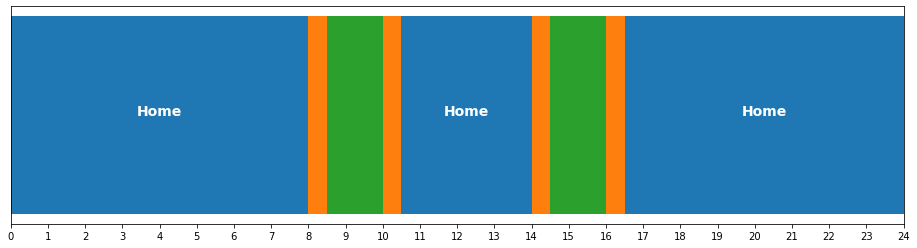

In [48]:
plot_activities(edu_pop.households['Jones'].people['Hugh'])

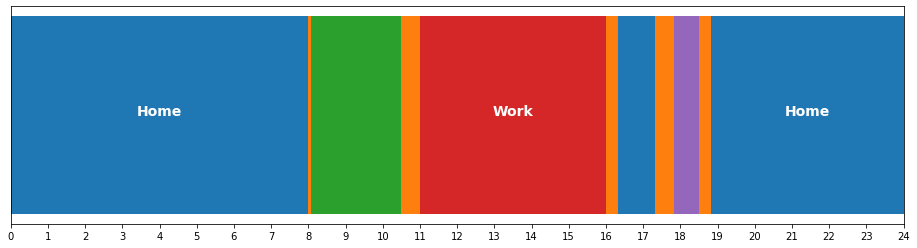

In [49]:
plot_activities(edu_pop.households['Jones'].people['Bridget'])

In [50]:
edu_pop.households['Jones'].people['Bridget'].plan.print()

0:	Activity(1 act:home, location:a, time:00:00:00 --> 08:00:00, duration:8:00:00)
1:	Leg(1 mode:walk, area:a --> b, time:08:00:00 --> 08:05:00, duration:0:05:00)
2:	Activity(2 act:escort, location:b, time:08:05:00 --> 10:30:00, duration:2:25:00)
3:	Leg(2 mode:pt, area:b --> c, time:10:30:00 --> 11:00:00, duration:0:30:00)
4:	Activity(3 act:work, location:c, time:11:00:00 --> 16:00:00, duration:5:00:00)
5:	Leg(3 mode:pt, area:c --> a, time:16:00:00 --> 16:20:00, duration:0:20:00)
6:	Activity(4 act:home, location:a, time:16:20:00 --> 17:20:00, duration:1:00:00)
7:	Leg(4 mode:pt, area:c --> a, time:17:20:00 --> 17:50:00, duration:0:30:00)
8:	Activity(5 act:shop, location:a, time:17:50:00 --> 18:30:00, duration:0:40:00)
9:	Leg(5 mode:pt, area:c --> a, time:18:30:00 --> 18:50:00, duration:0:20:00)
10:	Activity(6 act:home, location:a, time:18:50:00 --> 00:00:00, duration:5:10:00)


### PersonAttributeFilter
You can also use the `modify.PersonAttributeFilter` to only affect people with certain attributes.

In [51]:
def condition_job_education(val):
    return val == 'education'

policy_remove_education_and_escort = \
    HouseholdPolicy(
        RemoveActivity(['education', 'escort']), 
        PersonProbability(
             discrete_joint_distribution_sampler, 
             dict(mapping=key_mapping, distribution=key_distribution)),
        PersonAttributeFilter({'job': condition_job_education})
)

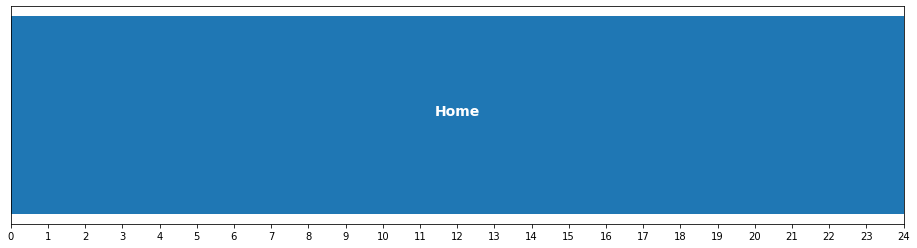

In [52]:
plot_activities(apply_policies(population, [policy_remove_education_and_escort]).households['Smith'].people['Bobby'])

In [53]:
policy_remove_education_and_escort = \
    HouseholdPolicy(
        RemoveActivity(['education', 'escort']), 
        [ActivityProbability(['education'], 0.9999),
         PersonProbability(
             discrete_joint_distribution_sampler, 
             dict(mapping=edu_mapping, distribution=edu_distribution)),
         PersonProbability(
             discrete_joint_distribution_sampler, 
             dict(mapping=key_mapping, distribution=key_distribution))])

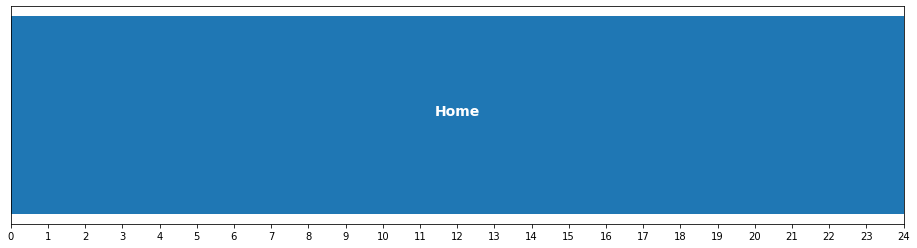

In [54]:
plot_activities(apply_policies(population, [policy_remove_education_and_escort]).households['Smith'].people['Bobby'])

## Remove Leisure Activities

Remove all leisure activities

In [55]:
policy_remove_leisure = \
    PersonPolicy(
        RemoveActivity(['leisure']), 
        PersonProbability(1.))

In [56]:
lei_pop = apply_policies(population, [policy_remove_leisure])
print_simple_stats(lei_pop)

Population total time at home: 66.25 hours
Population total travel time: 29.25 hours


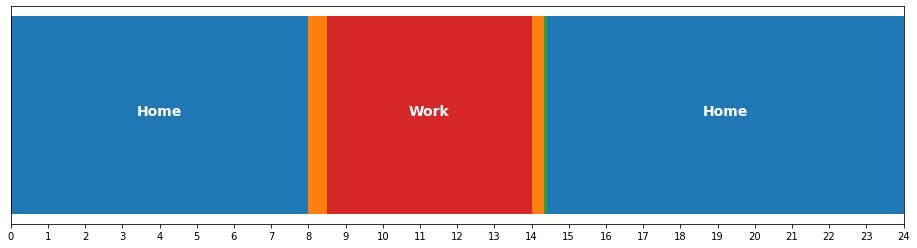

In [57]:
plot_activities(lei_pop.households['Smith'].people['Betty'])

## Unemployment/Furlough

Probabilistically remove all work activities from a person

In [58]:
key_mapping = ['key_worker']
key_distribution = {True: 0, False: 1}

In [59]:
policy_unemployment_and_furlough = \
    PersonPolicy(
        RemoveActivity(['work']), 
        [PersonProbability(
             discrete_joint_distribution_sampler, 
             dict(mapping=key_mapping, distribution=key_distribution)),
         PersonProbability(0.1)])

In [60]:
fur_pop = apply_policies(population, [policy_unemployment_and_furlough])
print_simple_stats(fur_pop)

Population total time at home: 64.58 hours
Population total travel time: 29.58 hours


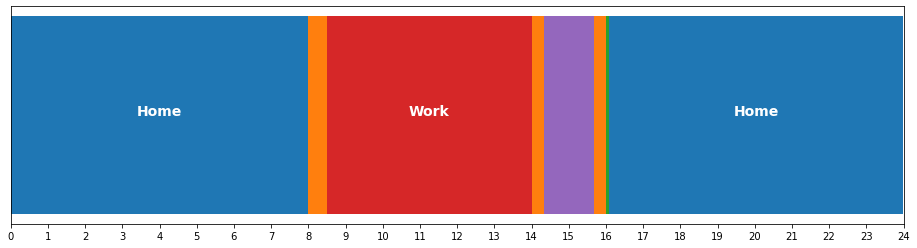

In [61]:
plot_activities(fur_pop.households['Smith'].people['Betty'])

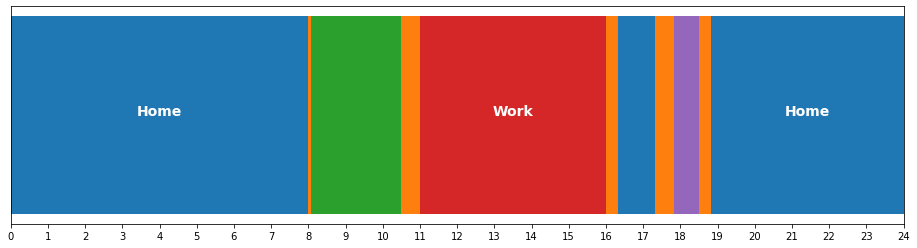

In [62]:
plot_activities(fur_pop.households['Jones'].people['Bridget'])

# Remove Shopping 

Probabilistically remove **individual** shopping activities from a person

In [63]:
policy_remove_shopping = \
    PersonPolicy(
        RemoveActivity(['shop']),
        ActivityProbability(['shop'], 1.))

In [64]:
shop_pop = apply_policies(population, [policy_remove_shopping])
print_simple_stats(shop_pop)

Population total time at home: 66.08 hours
Population total travel time: 28.75 hours


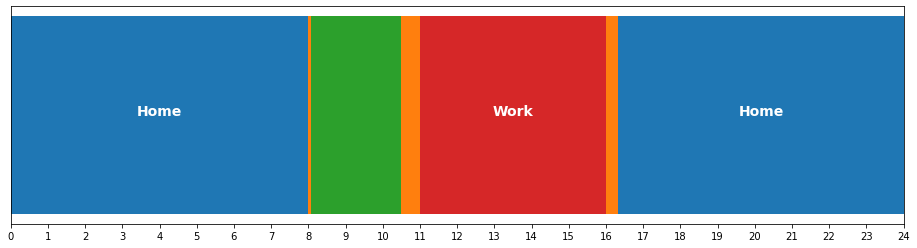

In [65]:
plot_activities(shop_pop.households['Jones'].people['Bridget'])

# All together now!

In [66]:
all_together_pop = apply_policies(
    population, 
    [policy_quarantine, 
     policy_remove_education_and_escort, 
     policy_remove_leisure, 
     policy_unemployment_and_furlough, 
     policy_remove_shopping])

print_simple_stats(all_together_pop)

Population total time at home: 18.08 hours
Population total travel time: 0.42 hours
